В даному ноутбуку вказано учбову реалізацію запропонованої в випускній-кваліфікаційній роботі
англомовної моделі для запрононованої та реалізованої в випускній-кваліфікаційній роботі системи аналізу настроїв у текстових повідомленнях.

Був використаний датасет з чіткою класифікацією типу емоція: злість, сум, радість, здувування.
Використано наступний датасет:
https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

Сама система знаходиться в окремому ноутбуці за наступним посиланням
https://colab.research.google.com/drive/1ZmlgVkDFcaf7xYx6UNqIIsH7YCz0MVJs?usp=sharing

# Train your english emotion analysis model here.

**Крок 1: Виконайте наступну клітинку, щоб завантажити усі необхідні бібліотеки.**

In [ ]:
#Інсталяція необхідних бібліотек
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

In [ ]:
#Виконайте цю клітинку, щоб підключити ваш Google Drive для збереження моделі
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Крок #2: Завантаження даних: для тренування, валідації та тестування.**

Даний датасет має 3 файли, тому необхідно передбачити таку можливість в архітектурі учбого тренувального ноутбука.
Завантажуемо відповідні дані у відповідні клітинки + призначення відповідних
параметрів до завантаженних даних.
Для коректної роботи маємо наступний порядок:


1.   Тренування - файл має назву "train.txt"
2.   Валідація - файл має назву "val.txt"
3.   Тестування - файл має назву "test.txt"

**ВАЖЛИВО:**

Для успішного тренування подібної учбової моделі, ваші дані повинні бути розмічені за наступною аналогією (без елементів списку):
im updating my blog because i feel shitty;sadness

1.   im updating my blog because i feel shitty;sadness
2.   i cant walk into a shop anywhere where i do not feel uncomfortable;fear

Перебачаєтсья, що ваш датасет буде мати наступні теги "емоцій":
joy, fear, surprise, sadness, anger

In [ ]:
# Функція для завантаження файлів датасету згідно набору
from google.colab import files

def upload_data(name):
  uploaded = files.upload()
  if uploaded:
    data_path = list(uploaded.keys())[0]
    df = pd.read_csv(data_path, header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
    return df
  else:
    print(f"No {name} data uploaded.")
    return None

# Upload train, test, and val datasets
print("Завантажте ваш train.txt файл")
df_train = upload_data("train")
print("Завантажте ваш val.txt файл")
df_val = upload_data("val")
print("Завантажте ваш test.txt файл")
df_test = upload_data("test")

# Check if all datasets were uploaded successfully
if df_train is not None and df_test is not None and df_val is not None:
  print("Всі датасети успішно завантажено!")
else:
  print("Одного чи декількох датасетів не вистачає, спробуйте ще раз.")

Завантажте ваш train.txt файл


Saving train.txt to train.txt
Завантажте ваш val.txt файл


Saving val.txt to val.txt
Завантажте ваш test.txt файл


Saving test.txt to test.txt
All datasets uploaded successfully!


**Крок №3: Перевірка наявних даних та дізнання кількості унікальних слів**

In [ ]:
X=df_train['Input']
lst=[]
for i in X:
  lst.append(len(i))


In [ ]:
len1=pd.DataFrame(lst)
len1.describe()

,0
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


In [ ]:
cts=[]
for i in range(7,301):
   ct=0
   for k in lst:
     if k==i:
       ct+=1
   cts.append(ct)

**Крок №4: Підготовка токенайзера для подальшої побудови самої моделі**

In [ ]:
# Fit the tokenizer with a reasonable maximum vocabulary size (e.g., 20000)
tokenizer = Tokenizer(num_words=20000, lower=True, oov_token='UNK')
tokenizer.fit_on_texts(X)

In [ ]:
X_train=tokenizer.texts_to_sequences(X)
X_train_pad=pad_sequences(X_train,maxlen=80,padding='post')

In [ ]:
df_train['Sentiment']=df_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [ ]:
Y_train=df_train['Sentiment'].values

In [ ]:
#One hot encoding for caterogical crossentropy
from keras.utils import to_categorical
#Оскільки наша учбова модель на даному датасеті використвує декілька різних емоцій, то ця функція втрати є найбільш приємною для використання.
#Кодуємо наші тренуючі дані:
Y_train_f=to_categorical(Y_train)

In [ ]:
Y_train_f[:6]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
#Кодування наших валідаційних даних
X_val=df_val['Input']
Y_val=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

X_val_f=tokenizer.texts_to_sequences(X_val)
X_val_pad=pad_sequences(X_val_f,maxlen=80,padding='post')

Y_val_f=to_categorical(Y_val)

In [ ]:
Y_val_f[:6]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

**Крок №5: Побудова RNN LSTM моделі**

In [ ]:
#Import all required libs (as checkup):
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout

In [ ]:
# Cell: Build and train the RNN (LSTM) model
model=Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 64, input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 64)            973696    
                                                                 
 dropout (Dropout)           (None, 80, 64)            0         
                                                                 
 bidirectional (Bidirection  (None, 80, 160)           92800     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 320)               410880    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1926      
                                                                 
Total params: 1479302 (5.64 MB)
Trainable params: 1479

In [ ]:
#Compile our test model:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Train our test model:
hist=model.fit(X_train_pad,Y_train_f,epochs=12,validation_data=(X_val_pad,Y_val_f))

Epoch 1/12
500/500 [==============================] - 259s 501ms/step - loss: 1.2078 - accuracy: 0.5356 - val_loss: 0.6381 - val_accuracy: 0.7940
Epoch 2/12
500/500 [==============================] - 239s 477ms/step - loss: 0.4541 - accuracy: 0.8439 - val_loss: 0.3039 - val_accuracy: 0.8925
Epoch 3/12
500/500 [==============================] - 232s 464ms/step - loss: 0.2669 - accuracy: 0.9050 - val_loss: 0.2513 - val_accuracy: 0.9080
Epoch 4/12
500/500 [==============================] - 233s 466ms/step - loss: 0.1931 - accuracy: 0.9293 - val_loss: 0.2084 - val_accuracy: 0.9225
Epoch 5/12
500/500 [==============================] - 237s 475ms/step - loss: 0.1656 - accuracy: 0.9389 - val_loss: 0.1950 - val_accuracy: 0.9235
Epoch 6/12
500/500 [==============================] - 236s 471ms/step - loss: 0.1282 - accuracy: 0.9511 - val_loss: 0.1744 - val_accuracy: 0.9325
Epoch 7/12
500/500 [==============================] - 233s 466ms/step - loss: 0.1141 - accuracy: 0.9569 - val_loss: 0.1775 -

**Крок 6: Графічне відображення ефективності тренування**

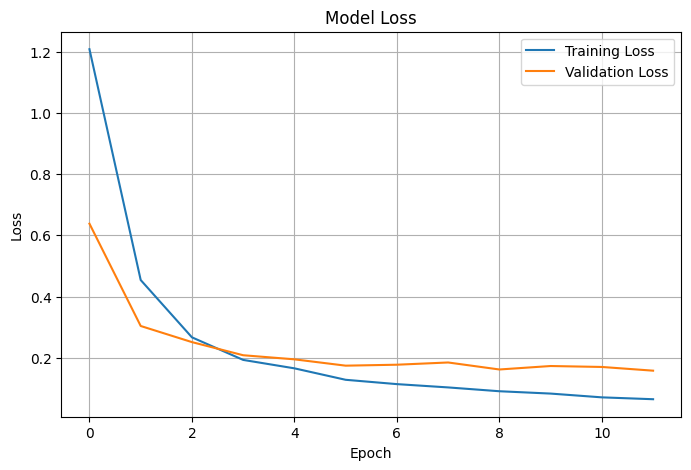

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  """
  Plots the training and validation loss curves from the training history.
  """
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_loss(hist)

**Крок 7: Перевірка розробленої учбової моделі на реальних даних перед збереженням.**

Це опціональний крок, користувач може продовжити використовувати створену модель
в самій системі.

In [ ]:
#Підготовка датасету для тестування, використвуючи завантажений раніше набір даних
X_test=df_test['Input']
Y_test=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

X_test_f=tokenizer.texts_to_sequences(X_test)
X_test_pad=pad_sequences(X_test_f,maxlen=80,padding='post')

Y_test_f=to_categorical(Y_test)

In [ ]:
#Evaluate our model on test data before user output:
model.evaluate(X_test_pad,Y_test_f)

63/63 [==============================] - 19s 298ms/step - loss: 0.1896 - accuracy: 0.9275


[0.18958993256092072, 0.9275000095367432]

In [ ]:
#Y_pred=model.predict_classes(X_test_pad)
Y_pred=np.argmax(model.predict(X_test_pad), axis=-1)

63/63 [==============================] - 11s 116ms/step


In [ ]:
#Creating function for key checkups:
def get_key(value):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    for key,val in dictionary.items():
          if (val==value):
            return key

In [ ]:
def predict(sentence):
  sentence_lst = [sentence]  # Convert sentence to a list for tokenization
  sentence_seq = tokenizer.texts_to_sequences(sentence_lst)
  sentence_padded = pad_sequences(sentence_seq, maxlen=80, padding='post')

  # Get class probabilities
  predictions = model.predict(sentence_padded)

  # Assuming your model has 5 classes (joy, anger, love, sadness, fear, surprise)
  class_names = ['joy', 'anger', 'love', 'sadness', 'fear', 'surprise']

  # Find the most probable class index (can be modified for custom logic)
  predicted_class_idx = np.argmax(predictions[0])

  # Print the predicted class based on class names
  print("Передбачена емоція:", class_names[predicted_class_idx])

In [ ]:
# Simple user input mode:
predict(str(input('Введіть англомовне речення : ')))

Введіть англомовне речення : I'll kill you
1/1 [==============================] - 0s 113ms/step
Передбачена емоція: anger


In [ ]:
# Simple user input mode:
predict(str(input('Введіть англомовне речення : ')))

Введіть англомовне речення : wow i'm so impressed
1/1 [==============================] - 0s 119ms/step
Передбачена емоція: surprise


**ФІНАЛ: Збержіть Вашу модель на Google Drive чи жорсткому диску ПК, вибравши
необхідну клітинку.**

Введіть ім'я Вашої моделі, можна використати звичайне значення.

Збереженна модель має формат .h5 + зберігається токенайзер моделі у форматі .pickle.

Назви обох файлів вводяться у наступні клітинки з текстовими полями.

In [ ]:
model_name = "rnn_eng" # @param {type:"string"}


In [ ]:
tokenizer_name = "rnn_eng" # @param {type:"string"}


In [ ]:
#Using next function to save our data to our Google Drive.
def save_model_and_tokenizer(model, tokenizer, model_name, tokenizer_name):
  """
  Saves the model and tokenizer to user's Google Drive.
  """
  model_path = f'/content/drive/MyDrive/emot-sys/models/{model_name}.h5'
  tokenizer_path = f'/content/drive/MyDrive/emot-sys/tokenizers/{tokenizer_name}.pickle'

  # Save model
  model.save(model_path)
  print(f"Model saved to: {model_path}")

  # Save tokenizer
  with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
  print(f"Tokenizer saved to: {tokenizer_path}")

# Saving usage:
save_model_and_tokenizer(model, tokenizer, model_name, tokenizer_name)

Model saved to: /content/drive/MyDrive/emot-sys/models/rnn_eng.h5
Tokenizer saved to: /content/drive/MyDrive/emot-sys/tokenizers/rnn_eng.pickle
